### Introduction

In this notebook, I'm trying to integrate the public notebook for Ventillator Pressure Competition written in Pytorch to Fastai. The reason is to leverage high level API of fastai to avoid repetitive pattern ( for example fititing with a scheduler learning rate, adding some callback  like ReduceLROnPlateau )


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.callback.progress import ProgressCallback
from fastai.optimizer import OptimWrapper
from torch import optim
from fastai.losses import MSELossFlat, L1LossFlat, LabelSmoothingCrossEntropyFlat, CrossEntropyLossFlat
from fastai.metrics import accuracy_multi, AccumMetric
from fastai.callback.schedule import Learner
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import IndexSplitter
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import KFold
from tqdm import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = np.load('../FE/train_f.npy')
train_idx = np.load('../FE/uout_train.npy')
targets = np.load('../FE/y_train.npy')
test = np.load('../FE/test_f.npy')

In [3]:
# train = train.reshape(-1, 80, train.shape[-1])
# test = test.reshape(-1, 80, train.shape[-1])

In [4]:
idx = list(range(len(train)))

In [5]:
class VentilatorDataset(Dataset):
    def __init__(self, data, target, idx):
        self.data = torch.from_numpy(data).float()
        if target is not None:
            self.targets = torch.from_numpy(target).float() * torch.from_numpy(idx)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if hasattr(self, 'targets'): return self.data[idx], self.targets[idx]
        else: return self.data[idx]

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_size=32):
        hidden = [400, 300, 200, 100]
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden[0],
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * hidden[0], hidden[1],
                             batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2 * hidden[1], hidden[2],
                             batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(2 * hidden[2], hidden[3],
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden[3], 50)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(50, 1)
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)

        return x

In [7]:
# next(model.parameters())

In [8]:
batch_size = 512
submission = pd.read_csv('../data/sample_submission.csv')
test_dataset = VentilatorDataset(test, None, None)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [10]:
########################## Experimenting with one fold

In [9]:
train_index=list(range(int(0.95*len(train)))) ## Change to have reasonable train/valid dataset
valid_index=list(range(int(0.05*len(train)), len(train)))

train_input, valid_input = train[train_index], train[valid_index]
train_idx, valid_idx = train_idx[train_index], train_idx[valid_index]
train_targets, valid_targets = targets[train_index], targets[valid_index]

train_dataset = VentilatorDataset(train_input, train_targets, train_idx)
valid_dataset = VentilatorDataset(valid_input, valid_targets, valid_idx)

print(train_dataset[0][1].shape)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False)

dls = DataLoaders(train_loader, valid_loader)
model = RNNModel()

torch.Size([80])


SuggestedLRs(valley=0.0003311311302240938)

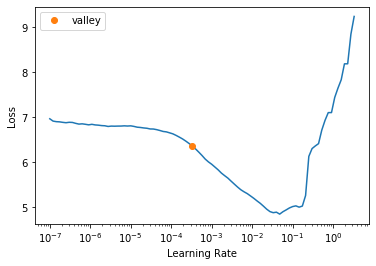

In [10]:
learn = Learner(dls, model, loss_func=L1LossFlat())
learn.lr_find()

In [11]:
df_test = pd.read_csv('../data/test.csv')

In [12]:
learn.fit_one_cycle(1, lr_max=3e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))
# 235

# preds_fold.append(preds)
# df_test[['id', 'pressure']].to_csv('submission.csv', index=False)

epoch,train_loss,valid_loss,time
0,0.914516,0.616711,00:33


In [13]:
preds = []
with torch.no_grad():
    for data in tqdm(test_loader):
        pred = model(data.to('cuda'))
        pred = torch.argmax(pred, dim=-1)
        pred = pred.squeeze(-1).flatten()
        preds.extend(pred.detach().cpu().numpy())


100%|██████████| 99/99 [00:05<00:00, 17.18it/s]


In [15]:
df_test['pressure'] = np.array(preds)

In [ ]:
df_test[['id', 'pressure']].to_csv('submission.csv', index=False)

In [21]:
########################################################################## Uncomment code below KFold Prediction

In [22]:
# kf = KFold(n_splits=5, shuffle=True)
# preds_fold = []
        
# for fold, (train_index, valid_index) in enumerate(kf.split(idx)):
#     preds = []
#     model = RNNModel().to('cuda')
#     print("FOLD:", fold)
#     print(train_index)
#     print(valid_index)

#     train_input, valid_input = train[train_index], train[valid_index]
#     train_targets, valid_targets = targets[train_index], targets[valid_index]

#     train_dataset = VentilatorDataset(train_input, train_targets)
#     valid_dataset = VentilatorDataset(valid_input, valid_targets)
    
#     train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
#     valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False)
    
#     dls = DataLoaders(train_loader, valid_loader)
#     learn = Learner(dls, model, loss_func=MSELossFlat())
#     learn.fit_one_cycle(1, lr_max=2e-3)
    
#     with torch.no_grad():
#         for data in test_loader:
#             pred = model(data.to('cuda')).squeeze(-1).flatten()
#             preds.extend(pred.detach().cpu().numpy())
#     preds_fold.append(preds)

In [23]:
# preds_fold = np.array(preds_fold)
# df_test['pressure'] = np.median(preds_fold, axis=0)
# df_test[['id', 'pressure']].to_csv('submission.csv', index=False)